In [90]:
import pandas as pd
import h5py
import re
import os

import matplotlib as mpl
# %matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors, matplotlib.cm 
import mplcursors

import numpy as np
from selenobot.datasets import *
from selenobot.files import * 
from selenobot.classifiers import *
from selenobot.embedders import *
from selenobot.tools import *

import scipy.stats
from scipy.stats import kstest, mannwhitneyu

from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA  
from sklearn.preprocessing import StandardScaler
import umap

from Bio import Align
from Bio.Align import substitution_matrices

import warnings
warnings.simplefilter('ignore')


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
# model = Classifier.load('../models/binary_model_len.pkl')
# df = pd.DataFrame(np.arange(5, 2000, 50))
# dataset = Dataset(df, n_features=1)
# results_df = model.predict(dataset)

# fig, ax = plt.subplots()
# ax.set_xlabel('sequence length (aa)')
# ax.set_ylabel('prediction')
# ax.set_title('binary len model behavior')

# lengths = df.values
# ax.plot(lengths, results_df.probability_truncated_selenoprotein, ls='--')
# ax.plot(lengths, results_df.prediction, color='tab:blue')

# plt.show()


In [2]:
# test_metadata_df = pd.read_csv('../data/test.csv', index_col=0)
# train_metadata_df = pd.read_csv('../data/train.csv', index_col=0)
# val_metadata_df = pd.read_csv('../data/val.csv', index_col=0)

# # Uh oh... 
# print('size of overlap between test and train:', len(np.intersect1d(test_metadata_df.index, train_metadata_df.index)))
# print('size of overlap between test and val:', len(np.intersect1d(test_metadata_df.index, val_metadata_df.index)))
# print('size of overlap between val and train:', len(np.intersect1d(val_metadata_df.index, train_metadata_df.index)))


In [3]:
def load_results(type_:str, file_names:list=['train.h5', 'test.h5', 'val.h5'], n_classes:int=2, results_dir:str='../data/results') -> pd.DataFrame:
    
    results = []
    model_name = f'binary_model_{type_}' if (n_classes == 2) else f'ternary_model_{type_}' 
    print(f'load_results: Loading results for {type_} encodings.')

    for file_name in file_names:
        results_file_name = f'predict_{os.path.splitext(file_name)[0]}_{model_name}.csv'
        results_path = os.path.join(results_dir, results_file_name)
        results_df = pd.read_csv(results_path, index_col=0)
        results_df['file_name'] = file_name

        # # If a label is specified, make sure only the binary results are included for a binary model. 
        # if 'label' in results_df.columns:
        #     label_filter = results_df.label.isin(list(range(n_classes)))
        #     print(f'load_results: Removing {len(results_df) - label_filter.sum()} entries from the results with labels not in {list(range(n_classes))}')
        #     results_df = results_df[label_filter]

        if 'label' in results_df.columns:
            acc = np.round(balanced_accuracy_score(results_df.label.values, results_df.prediction.values), 3)
            print(f'load_results: Accuracy of model {model_name} on {file_name}:', acc)
            
        results.append(results_df)

    return pd.concat(results)

In [335]:
results_df = load_results('aa_3mer', file_names=['test.h5', 'val.h5'])
incorrect_df = results_df[results_df.prediction != results_df.label]
correct_df = results_df[results_df.prediction == results_df.label]

# Difference of about 6 percentage points for the aa_2meer model, doing better on the testing data... why?

load_results: Loading results for aa_3mer encodings.
load_results: Accuracy of model binary_model_aa_3mer on test.h5: 0.765
load_results: Accuracy of model binary_model_aa_3mer on val.h5: 0.723


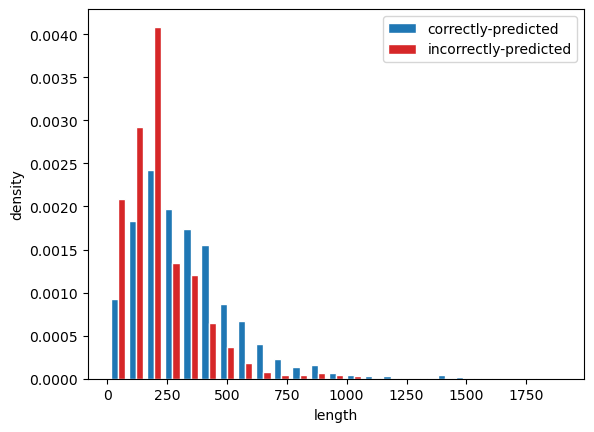

In [336]:
def plot_length_distribution(dfs:List[pd.DataFrame], ax:plt.Axes=None, bins:int=25, density:bool=False, color:List[str]=None):
    lengths = [df.seq.apply(len).values for df in dfs]
    _, _, patches = ax.hist(lengths, density=density, bins=bins, edgecolor='white', color=color)
    ax.set_ylabel('density' if density else 'count')
    ax.set_xlabel('length')

fig, ax = plt.subplots(1)
patches = plot_length_distribution([correct_df, incorrect_df], ax=ax, density=True, color=['tab:blue', 'tab:red'])
ax.legend(['correctly-predicted', 'incorrectly-predicted'])
plt.show()

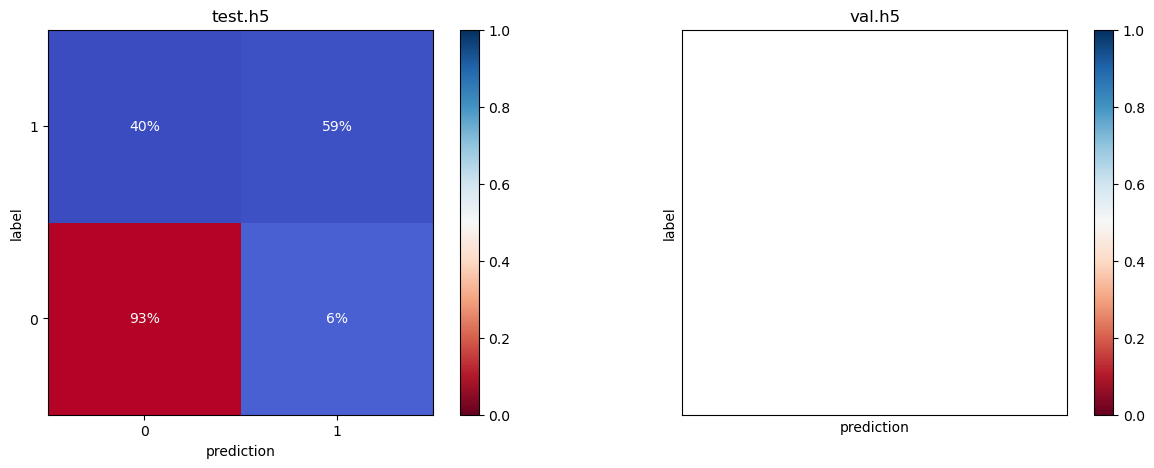

In [82]:
def plot_confusion_matrix(df:pd.DataFrame, ax:plt.Axes=None, cmap:str='RdBu', show_counts:bool=True, show_colorbar:bool=False):

    n_classes = len(df.label.unique())
    confusion_matrix = sklearn.metrics.confusion_matrix(df.label.values, df.prediction.values)
    #  The ith row and jth column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

    # Plot the normalized version so that the colormap can be compared across matrices. 
    image = ax.imshow(confusion_matrix / confusion_matrix.sum(), cmap='coolwarm', origin='lower')

    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xlabel('prediction')
    ax.set_ylabel('label')

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[-1]):
            text = confusion_matrix[i, j]
            if not show_counts: # Normalize so that the rows sum to one. 
                text = text / confusion_matrix[i].sum()
                text = f'{int(text * 100)}%'
            ax.text(j, i, text, ha='center', va='center', color='white')
            
    if show_colorbar:
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        ax.figure.colorbar(mappable, ax=ax)


fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

for ax, file_name in zip(axes, ['test.h5', 'val.h5']):
    df = results_df[results_df.file_name == file_name]
    ax.set_title(file_name)
    plot_confusion_matrix(df, ax=ax, show_counts=False, show_colorbar=True)

plt.show()
# There are a substantially higher proportion of false negatives in the validation set as compared to the testing set. 
# Seems worth looking into these (this is for the aa_2mer encoding type); there are about twice as many. 


Number of false negative in test.h5: 910
Number of false negative in val.h5: 1272


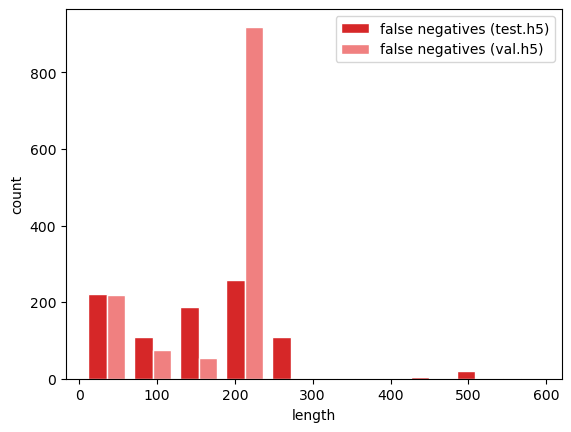

In [338]:
false_negatives_df = incorrect_df[incorrect_df.prediction == 0]
test_false_negatives_df = false_negatives_df[false_negatives_df.file_name == 'test.h5'] 
val_false_negatives_df = false_negatives_df[false_negatives_df.file_name == 'val.h5'] 

print('Number of false negative in test.h5:', len(test_false_negatives_df))
print('Number of false negative in val.h5:', len(val_false_negatives_df))

fig, ax = plt.subplots(1)
max_seq_length = 600
dfs = [df[df.seq.apply(len) < max_seq_length] for df in [test_false_negatives_df, val_false_negatives_df]]
plot_length_distribution(dfs, ax=ax, color=['tab:red', 'lightcoral'], bins=10, density=False)
ax.legend(['false negatives (test.h5)', 'false negatives (val.h5)'])
plt.show()

load_results: Loading results for aa_1mer encodings.
load_results: Accuracy of model binary_model_aa_1mer on val.h5: 0.793
load_results: Accuracy of model binary_model_aa_1mer on test.h5: 0.775
load_results: Loading results for aa_2mer encodings.
load_results: Accuracy of model binary_model_aa_2mer on val.h5: 0.797
load_results: Accuracy of model binary_model_aa_2mer on test.h5: 0.849
load_results: Loading results for aa_3mer encodings.
load_results: Accuracy of model binary_model_aa_3mer on val.h5: 0.723
load_results: Accuracy of model binary_model_aa_3mer on test.h5: 0.765


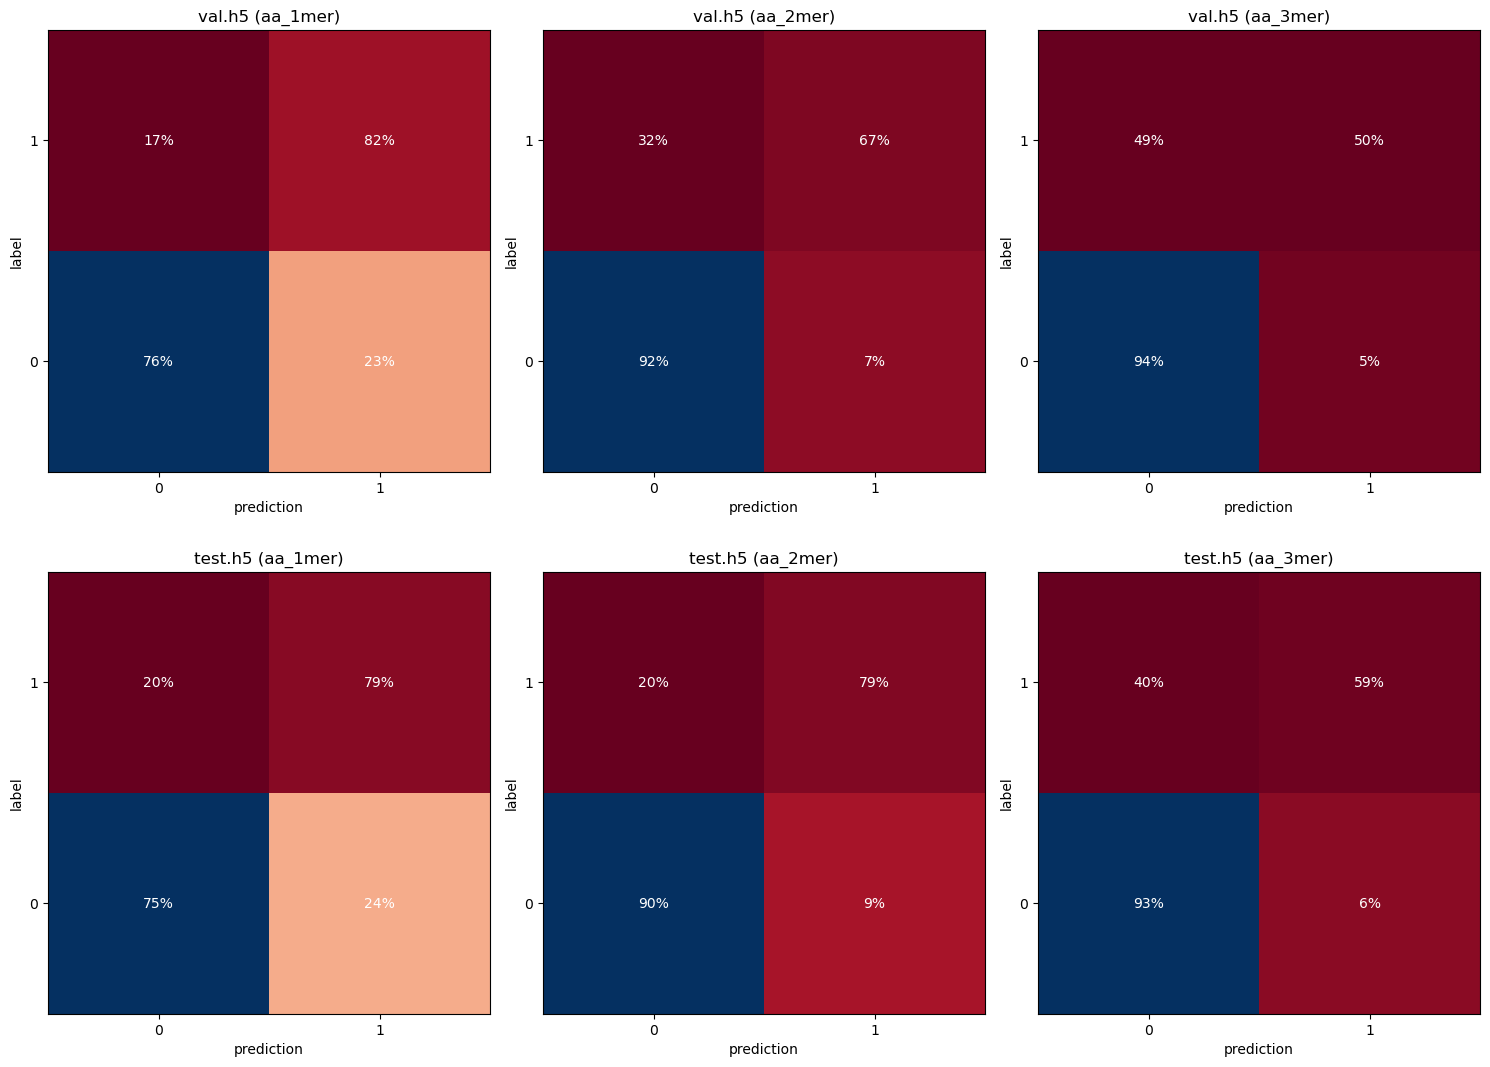

In [341]:
# Another thing I am confused about is why the aa_3mer model seems to be doing worse than everything else, including the length-based
# model. 

types = ['aa_1mer', 'aa_2mer', 'aa_3mer']
file_names = ['val.h5', 'test.h5']
results = {type_:load_results(type_, file_names=file_names) for type_ in types} # Load in all binary results (except PLM)

# Probably worth it to just start by looking at the confusion matrices... 

fig, axes = plt.subplots(nrows=2, ncols=len(types), figsize=(15, 11))

for i, file_name in enumerate(file_names):
    for j, type_ in enumerate(types):
        ax = axes[i, j]
        ax.set_title(f'{file_name} ({type_})')
        df = results[type_][results[type_].file_name == file_name]
        plot_confusion_matrix(df, ax=ax, show_counts=False)

plt.tight_layout()
plt.show()

# As model complexity increases, it seems as though thhey become better at detecting true negatives, but the proportion of false negatives also 
# increases. In other words, the models are airing on the side of classifying things as non-selenoproteins. This trade-off seems to be minimizing the loss
# function, as well as improving validation accuracy, i.e. reducing true positives by a little increases true negatives by a lot. Not sure if this
# is what we would want, though, depending on goals. 

# What about the loss function is causing this? Loss function is clearly prioritizing true negatives, which would make sese if the balancing isn't working
# correctly; there are many more negative instances than positive instances. However, the balance batching should have taken care of this. 

What is driving the increase in false negatives, and why is it more pronounced in the case of the `aa_3mer` encoding type? It seems as though the accuracy of the `aa_3mer` model on the training set is higher than the lower-complexity models, which rules out problems with the objective function (I was worried that mis-categorized full-length sequences were being penalized more due to class imbalance, even though the balance batch sampler should take care of that). 

This must have something to do with a failure to generalize (although I would have thought early stopping would have also addressed this). Looking at the training curves, it is clear that the `aa_3mer` model never reaches a validation accuracy as high as the others before clear overtraining begins. It's strange that this is presenting as an increase in false negatives, which implies that selenoproteins in the validation and testing sets "look like" full length proteins to the `aa_3mer` model, and to a lesser extent, the other two models. 

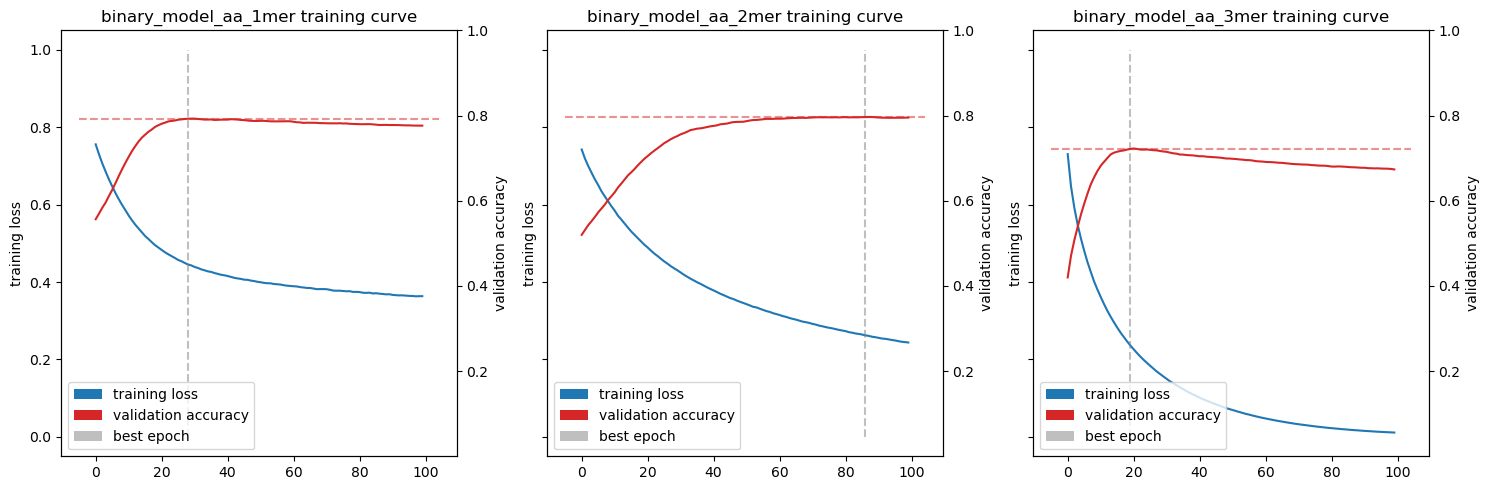

load_results: Loading results for aa_1mer encodings.
load_results: Accuracy of model binary_model_aa_1mer on train.h5: 0.819
load_results: Loading results for aa_2mer encodings.
load_results: Accuracy of model binary_model_aa_2mer on train.h5: 0.921
load_results: Loading results for aa_3mer encodings.
load_results: Accuracy of model binary_model_aa_3mer on train.h5: 0.952


In [340]:
def plot_training_curve(model_name:str, ax=plt.Axes):

    model = Classifier.load(f'../models/{model_name}')
    ax.set_title(model_name.replace('.pkl', '') + ' training curve')

    train_losses, val_accs = model.model.train_losses, model.model.val_accs 
    best_val_acc = val_accs[model.model.best_epoch]
    epochs = np.arange(model.model.epochs)

    ax.plot(epochs, train_losses)
    ax.set_ylabel('training loss') # Is this weighted? It shouldn't be... 
    ax.vlines([model.model.best_epoch], ymin=0, ymax=1, ls='--', color='gray', alpha=0.5)

    other_ax = ax.twinx()
    other_ax.plot(epochs, val_accs[:-1], color='tab:red')
    other_ax.set_ylabel('validation accuracy')
    other_ax.set_ylim(ymin=0, ymax=1)
    other_ax.hlines([best_val_acc], xmin=other_ax.get_xlim()[0], xmax=other_ax.get_xlim()[-1], color='tab:red', ls='--', alpha=0.5)
    
    yticks = [0.2, 0.4, 0.6, 0.8, 1.0]
    other_ax.set_yticks(yticks, labels=[np.round(y, 2) for y in yticks])

    handles = [Patch(facecolor='tab:blue'), Patch(facecolor='tab:red'), Patch(facecolor='gray', alpha=0.5)]
    ax.legend(handles=handles, labels=['training loss', 'validation accuracy', 'best epoch'], loc='lower left')


fig, axes = plt.subplots(sharey=True, figsize=(15, 5), ncols=3)
for ax, type_ in zip(axes, types):
    plot_training_curve(f'binary_model_{type_}.pkl', ax=ax)

plt.tight_layout()
plt.show()

train_results = {type_:load_results(type_, file_names=['train.h5']) for type_ in ['aa_1mer', 'aa_2mer', 'aa_3mer']}

# In this case, training losses can be directly compared (at least, I think they can, as the weighted random sampler is seeded)
# I think this means that the training 

What seems to be happening is that the k-mer and length-based models are failing to generalize to sequences which do not match those in the training set. In order to show this, I am going to try to show that mmseqs cluster identity is strongly correlated with the model output, more so than with the PLM. I think the best way to assess this generalizability is to correlate some measure of sequence "closeness" $c$ with the model's probability of outputting the correct result. For this metric, I will use minimum sequence identity to the MMseqs cluster representatives in the training set. 

$$c = min \{ d(s, s_t), s_t \in S_{train} \}$$

I am wondering if I should use something like pairwise distance between embeddings, or something like bit-score (from BLAST). I think the BLAST bit-score might be a little better for this, because some form of sequence identity was used to generate the dataset splits. Actually, it might be interesting to look into how MMSeqs works. Maybe this is related to why `aa_2mer` seems to be a bit better?

In [ ]:
train_metadata_df = pd.read_csv('../data/train.csv', index_col=0)
val_metadata_df = pd.read_csv('../data/val.csv', index_col=0)
test_metadata_df = pd.read_csv('../data/test.csv', index_col=0)

In [ ]:
for name in ['train', 'test', 'val']:
    metadata_df = pd.read_csv(f'../data/{name}.csv', index_col=0)
    # Only grab the things used in binary training... 
    metadata_df = metadata_df[metadata_df.label.isin([0, 1])]
    metadata_df = metadata_df[~metadata_df.seq.isnull()]
    # if name == 'train': # BLAST doesn't want to create a database with duplicated proteins.. 
    #     metadata_df = metadata_df[~metadata_df.index.duplicated()]
    FASTAFile.from_df(metadata_df, add_description=False).write(f'./out/binary_{name}.fa')

subject_path = './out/binary_train.fa'
blast = BLAST(cwd='./out')
blast.run('./out/binary_val.fa', subject_path, make_database=True, overwrite=True)

In [92]:
blast_df = BLASTFile('./out/binary_test.tsv').to_df()

# How many of the aligned labels actually match the right class?

# Add query labels to the BLAST data. 
blast_df = blast_df.merge(test_metadata_df[['label']], left_on='query_id', right_index=True, how='left')
blast_df = blast_df.rename(columns={'label':'query_label'})
# Add subject labels to the BLAST data. 
blast_df = blast_df.merge(train_metadata_df[['label']], left_on='subject_id', right_index=True, how='left')
blast_df = blast_df.rename(columns={'label':'subject_label'})

query_subject_same_label = blast_df.query_label == blast_df.subject_label
print('Fraction of hits where the subject and query labels are the same :', query_subject_same_label.sum() / len(blast_df))

cols = []
for same_label, df in blast_df.groupby(query_subject_same_label):
    grouped_df = df.groupby('id')

    n_hits = grouped_df.apply(len)
    n_hits.name = 'n_hits_same_label' if same_label else 'n_hits_diff_label'

    mean_bit_score = grouped_df.apply(lambda df : df.bit_score.mean())
    mean_bit_score.name = 'mean_bit_score_same_label' if same_label else 'mean_bit_score_diff_label'

    mean_sequence_identity = grouped_df.apply(lambda df : df.sequence_identity.mean())
    mean_sequence_identity.name = 'mean_sequence_identity_same_label' if same_label else 'mean_sequence_identity_diff_label'

    cols += [n_hits, mean_bit_score, mean_sequence_identity]


Fraction of hits where the subject and query labels are the same : 0.9950746349895738


In [93]:
blast_df

,query_id,subject_id,sequence_identity,alignment_length,mismatch,num_gap_openings,query_alignment_start,query_alignment_end,subject_alignment_start,subject_alignment_end,e_value,bit_score,query_coverage_per_subject,query_coverage_per_pair,query_sequence_length,subject_sequence_length,query_label,subject_label
id,,,,,,,,,,,,,,,,,,
Q0RAT5,Q0RAT5,Q8YM92,49.176,364,168,4,27,388,19,367,2.910000e-113,339.0,78,78,465,381,0,0
Q0RAT5,Q0RAT5,A1TAI4,50.789,380,150,8,30,397,2,356,2.900000e-112,337.0,79,79,465,373,0,0
Q0RAT5,Q0RAT5,Q1B8V9,51.389,360,146,6,48,397,31,371,5.030000e-110,331.0,75,75,465,388,0,0
Q0RAT5,Q0RAT5,Q160M2,49.030,361,168,6,27,386,6,351,1.480000e-108,327.0,77,77,465,363,0,0
Q0RAT5,Q0RAT5,Q110U3,50.932,322,149,2,48,366,33,348,2.120000e-108,327.0,69,69,465,381,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A9AXK0,A9AXK0,B8FMU9,33.333,120,71,2,3,122,8,118,6.800000e-07,45.8,98,98,123,118,0,0
A9AXK0,A9AXK0,P25814,27.619,105,74,2,1,104,1,104,1.040000e-06,45.4,85,85,123,116,0,0
A9AXK0,A9AXK0,A1T0M7,29.808,104,71,2,1,103,6,108,1.050000e-06,45.4,84,84,123,118,0,0


In [75]:
# Can the same query-subject pair occur multiple times, i.e. multiple matches between sequences?
n = 0
for query_id, df in blast_df.groupby('query_id'):
    subject_id_counts = df.value_counts('subject_id')
    if (subject_id_counts > 1).sum() > 0:
        n += 1

print(f'{n} duplicate query-subject pairs.')


8196 uplicate query-subject pairs.


In [68]:
types = ['aa_1mer', 'aa_2mer', 'aa_3mer', 'len', 'plm']
file_names = ['val.h5', 'test.h5']
results = {type_:load_results(type_, file_names=file_names) for type_ in types} # Load in all binary results. 

load_results: Loading results for aa_1mer encodings.
load_results: Accuracy of model binary_model_aa_1mer on val.h5: 0.793
load_results: Accuracy of model binary_model_aa_1mer on test.h5: 0.775
load_results: Loading results for aa_2mer encodings.
load_results: Accuracy of model binary_model_aa_2mer on val.h5: 0.797
load_results: Accuracy of model binary_model_aa_2mer on test.h5: 0.849
load_results: Loading results for aa_3mer encodings.
load_results: Accuracy of model binary_model_aa_3mer on val.h5: 0.723
load_results: Accuracy of model binary_model_aa_3mer on test.h5: 0.765
load_results: Loading results for len encodings.
load_results: Accuracy of model binary_model_len on val.h5: 0.829
load_results: Accuracy of model binary_model_len on test.h5: 0.791
load_results: Loading results for plm encodings.
load_results: Accuracy of model binary_model_plm on val.h5: 0.996
load_results: Accuracy of model binary_model_plm on test.h5: 0.997


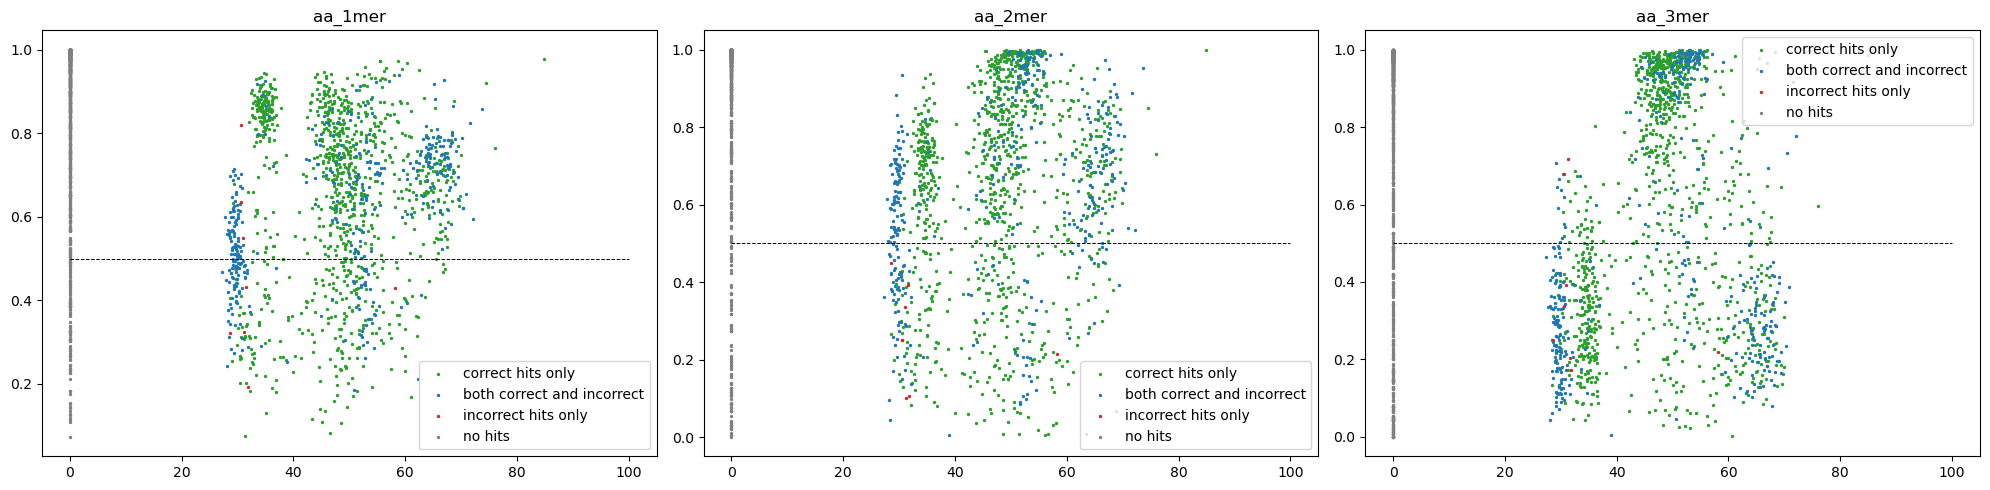

In [71]:
fig, axes = fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

for ax, type_ in zip(axes, ['aa_1mer', 'aa_2mer', 'aa_3mer']):
    results_df = results[type_]
    results_df = results_df[results_df.file_name == 'test.h5']
    for col in cols:
        if col.name not in results_df.columns:
            results_df = results_df.merge(col, left_index=True, right_index=True, how='left').fillna(0)

    label_1_results_df = results_df[(results_df.label == 1)]
    label_1_results_df_same = label_1_results_df[(label_1_results_df.n_hits_diff_label == 0) & (label_1_results_df.n_hits_same_label > 0)]
    label_1_results_df_diff = label_1_results_df[(label_1_results_df.n_hits_diff_label > 0) & (label_1_results_df.n_hits_same_label == 0)]
    label_1_results_df_both = label_1_results_df[(label_1_results_df.n_hits_diff_label > 0) & (label_1_results_df.n_hits_same_label > 0)]
    label_1_results_df_none = label_1_results_df[(label_1_results_df.n_hits_diff_label + label_1_results_df.n_hits_same_label) == 0]

    # Probably good to focus primarily on the true truncated selenoproteins, as those seem to be at the root of the weird effect. 

    ax.scatter(label_1_results_df_same.mean_sequence_identity_same_label, label_1_results_df_same.probability_truncated_selenoprotein, s=2, alpha=1, color='tab:green')
    ax.scatter(label_1_results_df_both.mean_sequence_identity_same_label, label_1_results_df_both.probability_truncated_selenoprotein, s=2, alpha=1, color='tab:blue')
    ax.scatter(label_1_results_df_diff.mean_sequence_identity_diff_label, label_1_results_df_diff.probability_truncated_selenoprotein, s=2, alpha=1, color='tab:red')
    ax.scatter(label_1_results_df_none.mean_sequence_identity_same_label, label_1_results_df_none.probability_truncated_selenoprotein, s=2, alpha=1, color='gray')
    ax.hlines([0.5], xmax=100, xmin=0, color='black', ls='--', lw=0.7)
    ax.legend(['correct hits only', 'both correct and incorrect', 'incorrect hits only', 'no hits'])
    ax.set_title(type_)

# ax.set_xlim(0, 1000)
# Higher bit-scores mean higher similarity, or a better alignment. 
plt.tight_layout()
plt.show()


In [43]:
results_df

,probability_full_length,probability_truncated_selenoprotein,prediction,mmseqs_representative,mmseqs_cluster,domain,kingdom,phylum,class,order,...,sec_index,sec_count,truncation_size,truncation_ratio,original_length,file_name,n_hits_diff_label,mean_bit_score_diff_label,n_hits_same_label,mean_bit_score_same_label
A0A023VXA2,0.539720,0.460280,0,A0A023VXA2,354,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Aurantimonadaceae,...,0.0,0.0,0.0,0.000000,0.0,test.h5,0.0,0.0,3.0,56.966667
A0A059WYP6,0.563153,0.436847,0,A0A059WYP6,30241,Bacteria,environmental samples,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,test.h5,0.0,0.0,16.0,63.037500
A0A069RAL1-,0.407443,0.592557,1,A0A367Z0R6-,19091,Bacteria,Bacillota,Clostridia,Peptostreptococcales,Peptoclostridiaceae,...,150.0,1.0,91.0,0.377593,241.0,test.h5,1.0,263.0,499.0,55.196794
A0A069RHX7-,0.352264,0.647736,1,A0A367Z0R6-,19091,Bacteria,Bacillota,Clostridia,Peptostreptococcales,Peptoclostridiaceae,...,150.0,1.0,91.0,0.377593,241.0,test.h5,1.0,261.0,499.0,55.600200
A0A073CEA3,0.685672,0.314328,0,A0A073CEA3,10009,Bacteria,Cyanobacteriota,Cyanophyceae,Oscillatoriophycideae,Oscillatoriales,...,0.0,0.0,0.0,0.000000,0.0,test.h5,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V5YM14,0.659112,0.340888,0,V5YM14,31773,Bacteria,Pseudomonadota,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,...,0.0,0.0,0.0,0.000000,0.0,test.h5,0.0,0.0,0.0,0.000000
V6F2B6,0.359241,0.640759,1,V6F2B6,6622,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Rhodospirillaceae,...,0.0,0.0,0.0,0.000000,0.0,test.h5,0.0,0.0,50.0,97.112000
W6RJ11,0.613087,0.386913,0,Q89E06,26809,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,...,0.0,0.0,0.0,0.000000,0.0,test.h5,0.0,0.0,0.0,0.000000
W8FLH9,0.578289,0.421711,0,W8FLH9,33724,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,Sphaerotilaceae,...,0.0,0.0,0.0,0.000000,0.0,test.h5,0.0,0.0,0.0,0.000000


In [55]:
blast_df

,query_id,subject_id,sequence_identity,alignment_length,mismatch,num_gap_openings,query_alignment_start,query_alignment_end,subject_alignment_start,subject_alignment_end,e_value,bit_score
id,,,,,,,,,,,,
P39147,P39147,P46846,26.027,219,131,10,28,229,22,226,8.390000e-09,55.5
Q43992,Q43992,Q52154,33.198,247,161,1,21,267,43,285,1.090000e-37,135.0
O83046,O83046,Q52154,35.366,246,156,1,29,274,43,285,6.950000e-46,157.0
P44079,P44079,P02975,53.571,28,13,0,1,28,4,31,2.700000e-02,35.0
A0A0H2UR90,A0A0H2UR90,A0A0H2URJ6,32.500,120,80,1,289,407,283,402,9.870000e-13,70.9
...,...,...,...,...,...,...,...,...,...,...,...,...
B0B910,B0B910,C0QIZ3,40.244,82,48,1,1,82,1,81,2.810000e-13,62.4
H9N291-,H9N291-,O54037,42.029,276,155,4,279,552,6,278,1.800000e-64,214.0
Q9Z840-,Q9Z840-,D5VAD8,27.143,70,51,0,301,370,35,104,9.100000e-01,32.7


It seems as though what's happening is that the length and k-mer based models are failing to generalize; there are specific groups in the testing dataset which are being entirely mis-classified by these models, which is not happening for the PLM embedding model. I want a figure that communicates this, i.e. shows that the amino acid models tend to mis-categorize entire homology groups. I also want to communicate that these errors are substantially contributing to the total pool of mis-classified sequences. 

I'm thinking I should display the clusters which are contributing most to the "incorrect" pool, and then create a bar plot where the y-axis is the poportion of the cluster which is mis-classified. It also might be good to separate the bars by false positive versus false negative. 

*Should I include stats on the validation dataset too? I honestly think the test set is more interesting, but it does seem weird that the validation accuracy keeps increasing, but the test accuracy goes down... This implies that the model is not underfitting, which is good.*

bars represent 56 out of 200 misclassified points.


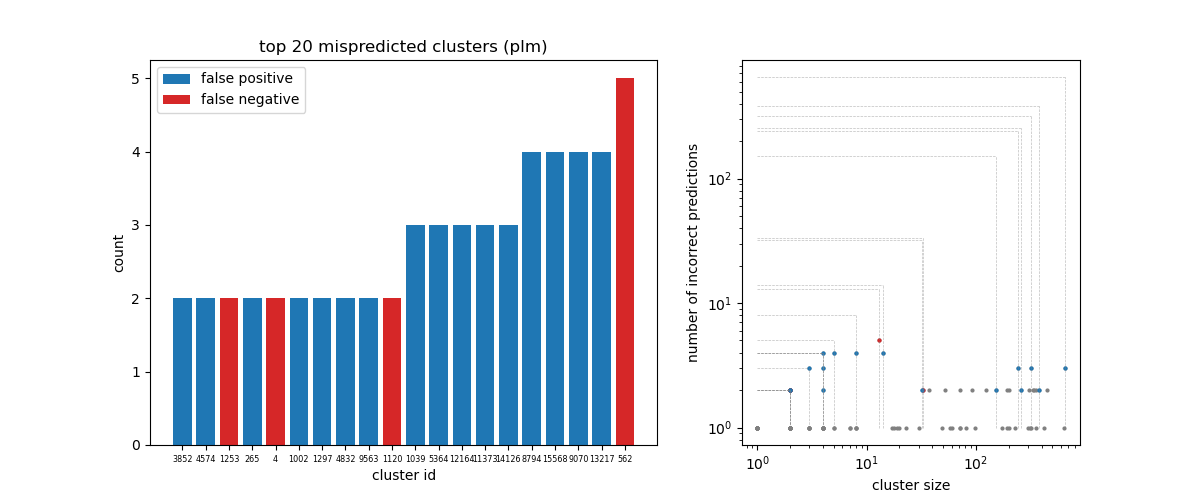

In [4]:
# On the plot, I want to show... 
# 1. How much each cluster contributes relative to the others, as well as the total number of mistakes. 
# 2. How much of the cluster is false positive versus false negative. 
# 3. What fraction of the cluster is correct. 

# I think I will use color to indicate false positive versus false negative, and plot cluster fraction on the y-axis. 
# Might need to do another plot to communicate the contributions of the clusters. Possibly some kind of scatter plot showing absolute cluster
# size versus number of incorrect predictions, and then label the points of the clusters shown in the bar plot.     

fig, axes = plt.subplots(ncols=2, figsize=(12, 5), width_ratios=[0.6, 0.4])

incorrect_df = test_metadata_df[~test_metadata_df.correct]
incorrect_clusters = incorrect_df.groupby('mmseqs_cluster').apply(len).sort_values(ascending=False) # These are in order... 

plot_df = {'cluster_id':[], 'false_positive':[], 'false_negative':[], 'false_positive_ratio':[], 'false_negative_ratio':[], 'total_incorrect_ratio':[], 'total':[], 'total_incorrect':[]}
for cluster_id, cluster_df in test_metadata_df.groupby('mmseqs_cluster'):
    if cluster_id in incorrect_clusters:
        n = len(cluster_df)
        nfp = ((cluster_df.prediction == 1) & (cluster_df.label == 0)).sum()
        nfn = ((cluster_df.prediction == 0) & (cluster_df.label == 1)).sum()
        # print(f'cluster_id={cluster_id}, n={n}, nfp={nfp}, nfn={nfn}')

        plot_df['total'].append(len(cluster_df))
        plot_df['total_incorrect'].append(nfp + nfn)
        plot_df['total_incorrect_ratio'].append((nfp + nfn) / n)
        plot_df['false_positive'].append(nfp)
        plot_df['false_positive_ratio'].append(nfp / n)
        plot_df['false_negative'].append(nfn)
        plot_df['false_negative_ratio'].append(nfn / n)
        plot_df['cluster_id'].append(cluster_id)

plot_df = pd.DataFrame(plot_df).set_index('cluster_id')
plot_df = plot_df.sort_values('total_incorrect')

n_clusters = 20

top_incorrect_clusters = incorrect_clusters.index[:n_clusters]
top_plot_df = plot_df[plot_df.index.isin(top_incorrect_clusters)]
axes[0].bar(np.arange(n_clusters), top_plot_df.false_positive, color='tab:blue')
axes[0].bar(np.arange(n_clusters), top_plot_df.false_negative, bottom=top_plot_df.false_positive, color='tab:red')
axes[0].legend(['false positive', 'false negative'])
axes[0].set_xticks(np.arange(n_clusters), labels=top_plot_df.index, fontsize='xx-small')
axes[0].set_xlabel('cluster id')
axes[0].set_ylabel('count')
# axes[0].set_yscale('log')
axes[0].set_title(f'top {n_clusters} mispredicted clusters ({feature_type})')

axes[1].set_ylabel('number of incorrect predictions')
axes[1].set_xlabel('cluster size')

axes[1].scatter(plot_df.total, plot_df.total_incorrect, color='gray', s=4)
for row in top_plot_df.itertuples():
    axes[1].vlines([row.total], ymin=1, ymax=row.total, ls='--', color='gray', lw=0.5, alpha=0.5)
    axes[1].hlines([row.total], xmin=1, xmax=row.total, ls='--', color='gray', lw=0.5, alpha=0.5)


plot_df_mostly_fp = top_plot_df[top_plot_df.false_positive_ratio > top_plot_df.false_negative_ratio]
plot_df_mostly_fn = top_plot_df[top_plot_df.false_positive_ratio < top_plot_df.false_negative_ratio]
axes[1].scatter(plot_df_mostly_fn.total, plot_df_mostly_fn.total_incorrect, color='tab:red', s=4)
axes[1].scatter(plot_df_mostly_fp.total, plot_df_mostly_fp.total_incorrect, color='tab:blue', s=4)


# cluster_50_x = plot_df[plot_df.index == 50].total.item()
# cluster_50_y = plot_df[plot_df.index == 50].total_incorrect.item()
# axes[1].scatter([cluster_50_x], [cluster_50_y], color='black', s=4)
# axes[1].text(cluster_50_x, cluster_50_y, '50')

axes[1].set_xscale('log')
axes[1].set_yscale('log')

print(f'bars represent {top_plot_df.total_incorrect.sum()} out of {plot_df.total_incorrect.sum()} misclassified points.')

plt.show()


In [120]:
# fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# for ax, metadata_df in zip(axes, [test_metadata_df, val_metadata_df]):
#     false_pos = metadata_df[(metadata_df.label == 0) & (metadata_df.prediction == 1)]
#     false_neg = metadata_df[(metadata_df.label == 1) & (metadata_df.prediction == 0)]
#     correct = metadata_df[metadata_df.correct]
    
#     # _, bin_edges, _ = ax.hist((false_pos.seq.apply(len), false_neg.seq.apply(len), correct.seq.apply(len)), density=False, bins=10, color=['tab:blue', 'tab:red', 'tab:green'])
#     _, bin_edges, _ = ax.hist((false_pos.seq.apply(len), false_neg.seq.apply(len)), density=False, bins=10, color=['tab:blue', 'tab:red']) # , 'tab:green'])
#     ax.legend(['false positive', 'false negative']) # , 'correct'])
#     ax.set_ylabel('count')
#     ax.set_xlabel('sequence length (aa)')
#     # print(bin_edges)

# axes[0].set_title('test dataset')
# axes[1].set_title('validation dataset')

# plt.show()


In [112]:

# fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# for ax, metadata_df in zip(axes, [test_metadata_df, val_metadata_df]):
#     correct_df = metadata_df[metadata_df.correct]
#     incorrect_df = metadata_df[~metadata_df.correct]
#     incorrect_clusters = incorrect_df.groupby('mmseqs_cluster').apply(len).sort_values(ascending=False).index # These are in order...
#     # Assign colors to the top five largest incorrect clusters. 
#     cmap = plt.get_cmap('RdBu')
#     # color_map = {cluster_id:cmap(i) for i, cluster_id in enumerate(incorrect_clusters[:5])}
#     color_map = dict()
#     for cluster_id in incorrect_clusters:
#         cluster_df = metadata_df[metadata_df.mmseqs_cluster == cluster_id]
#         correct_ratio = cluster_df.correct.sum() / len(cluster_df)
#         color_map[cluster_id] = cmap(correct_ratio)

#     for cluster_id, cluster_df in incorrect_df.groupby('mmseqs_cluster'): 
#         if len(cluster_df) > 1:
#             color = color_map.get(cluster_id)
#             ax.scatter(cluster_df.seq.apply(len).values, cluster_df.model_output.values, color=color, s=3)
#     ax.set_xlim(xmax=1000)

#     # ax.legend(handles=[Patch(facecolor=color_map[cluster_id]) for cluster_id in incorrect_clusters[:5]], labels=list(incorrect_clusters[:10]))
#     ax.set_xlabel('sequence length (aa)')
#     ax.set_ylabel('model output')
#     ax.hlines(0.5, xmin=0, xmax=ax.get_xlim()[-1], lw=0.7, ls='--', colors='black')
#     ax.text(0.6, 0.55, 'false positive', transform=ax.transAxes)
#     ax.text(0.6, 0.45, 'false negative', transform=ax.transAxes)
#     cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, 1), cmap='RdBu'), ax=ax, orientation='vertical', label='percent of cluster correct')

# axes[0].set_title(f'test dataset incorrect predictions ({feature_type})')
# axes[1].set_title(f'validation dataset incorrect predictions ({feature_type})')

# plt.tight_layout()
# plt.show()
    


In [111]:
# correct_df = test_metadata_df[test_metadata_df.correct]
# incorrect_df = test_metadata_df[~test_metadata_df.correct]
# correct_idxs, incorrect_idxs = np.where(test_metadata_df.correct.values), np.where(~test_metadata_df.correct.values)

# incorrect_clusters = incorrect_df.groupby('mmseqs_cluster').apply(len).sort_values(ascending=False).index # These are in order... 
# incorrect_cluster_idxs = {cluster_id:np.where(test_metadata_df.mmseqs_cluster == cluster_id) for cluster_id in incorrect_clusters}

# scaler = StandardScaler()
# embeddings = copy.deepcopy(test_dataset.embeddings.numpy())
# embeddings = scaler.fit_transform(embeddings)

# n_components = 2
# correct_df = test_metadata_df[test_metadata_df.correct]
# incorrect_df = test_metadata_df[~test_metadata_df.correct]
# correct_idxs, incorrect_idxs = np.where(test_metadata_df.correct.values), np.where(~test_metadata_df.correct.values)

# incorrect_clusters = incorrect_df.groupby('mmseqs_cluster').apply(len).sort_values(ascending=False).index # These are in order... 
# incorrect_cluster_idxs = {cluster_id:np.where(test_metadata_df.mmseqs_cluster == cluster_id) for cluster_id in incorrect_clusters}

# pca = PCA(n_components=n_components)
# components = pca.fit_transform(embeddings)
# explained_var = pca.explained_variance_ratio_

# components_correct, components_incorrect = components[correct_idxs], components[incorrect_idxs]

# fig, ax = plt.subplots()

# ax.scatter(components_correct[:, 0].ravel(), components_correct[:, 1].ravel(), color='black', s=3)
# ax.scatter(components_incorrect[:, 0].ravel(), components_incorrect[:, 1].ravel(), color='gray', s=3)

# # Assign colors to the top five largest incorrect clusters. 
# cmap = plt.get_cmap('tab10')
# color_map = {cluster_id:cmap(i) for i, cluster_id in enumerate(incorrect_clusters[:5])}

# for cluster_id in incorrect_clusters[::-1]: # Want to plot the smallest clusters first... 
#     if cluster_id in color_map:
#         idxs = incorrect_cluster_idxs[cluster_id]
#         color = color_map[cluster_id]
#         ax.scatter(components[idxs, 0].ravel(), components[idxs, 1].ravel(), color=color, s=3)

# ax.set_xlabel(f'pca 1 ({np.round(explained_var[0], 4)})')
# ax.set_ylabel(f'pca 2 ({np.round(explained_var[1], 4)})')
# ax.legend(handles=[Patch(facecolor=color_map[cluster_id]) for cluster_id in incorrect_clusters[:5]], labels=list(incorrect_clusters[:5]))
# # Add hover labels
# # cursor = mplcursors.cursor(scatter, hover=True)
# # cursor.connect('add', lambda sel: sel.annotation.set_text(test_metadata_df.mmseqs_cluster[sel.index]))

# plt.show()


In [6]:
confusion_matrix = sklearn.metrics.confusion_matrix(test_metadata_df.label.values, test_metadata_df.prediction.values)

image = ax.imshow(confusion_matrix, cmap='RdBu')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xlabel('prediction')
ax.set_ylabel('label')
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[-1]):
        text = ax.text(i, j, confusion_matrix[i, j], ha='center', va='center', color='white')

image = ax.figure.colorbar(image, ax=ax)
# Most of the erroneous predictions are false positives. 
plt.show()

In [ ]:
bacteria_metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'validation', 'bac120_metadata_r207.tsv'), sep='\t')
# Only want to deal with the representatives... 
bacteria_metadata_df = bacteria_metadata_df[bacteria_metadata_df.gtdb_representative == 't']
bacteria_genome_ids = bacteria_metadata_df.accession.values.tolist()
bacteria_genome_ids = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in bacteria_genome_ids] # Remove prefixes...
print('Number of bacterial genomes:', len(bacteria_genome_ids))

Number of bacterial genomes: 62291


In [ ]:
# For the sake of speeding things up, going to use a subset of GTDB genomes. I will grab the highest-completion representative
# genome from each bacterial phylum. 
bacteria_metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'validation', 'bac120_metadata_r207.tsv'), sep='\t')
bacteria_metadata_df = bacteria_metadata_df[bacteria_metadata_df.gtdb_representative == 't'] # Get the representatives. 
# Extract the phylum... 
phylum = [re.search(r'p__([^;]+);', taxonomy).group(1) for taxonomy in bacteria_metadata_df.gtdb_taxonomy]
bacteria_metadata_df['phylum'] = phylum

print('Number of representative genomes:', len(bacteria_metadata_df))
print('Number of phyla:', len(np.unique(phylum)))

subset_df = [] # For storing the genome from each phylum with the highest completeness.. 
for _, phylum_df in bacteria_metadata_df.groupby('phylum'):
    phylum_df = phylum_df.sort_values('checkm_completeness', ascending=False)
    subset_df.append(phylum_df.iloc[0].copy())
subset_df = pd.DataFrame(subset_df)

# Remove the prefixes from the genome IDs. 
subset_df = subset_df.rename(columns={'accession':'genome_id'})
subset_df.genome_id = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in subset_df.genome_id]
subset_df.set_index('genome_id').to_csv(os.path.join(DATA_DIR, 'validation', 'bac120_metadata_r207_subset.csv'))

Number of representative genomes: 62291
Number of phyla: 169


In [ ]:
# Want to download the GTDB ORFs for the genomes in the subsample... 
# This is the genome with the highest completeness from each bacterial phylum!
genome_ids = pd.read_csv(os.path.join(DATA_DIR, 'validation', 'bac120_metadata_r207_subset.csv')).genome_id

# Obtain the relevant data from Find-A-Bug...
gtdb_df = []
for genome_id in tqdm(genome_ids, desc='Downloading genes from Find-A-Bug...'):
    genome_df = []
    query = fabapi.Query('proteins')
    query.equal_to('genome_id', genome_id)
    for page_df in query:
        genome_df.append(page_df)
    # Concatenate the results for the genome and add to the complete DataFrame. 
    genome_df = pd.concat(genome_df)
    gtdb_df.append(genome_df)  

gtdb_df = pd.concat(gtdb_df).set_index('gene_id')
gtdb_df.to_csv(os.path.join(DATA_DIR, 'validation', 'bac120_proteins_r207_subset.csv'))

Total number of proteins in the subset: 479429
Average length of proteins with length < 1000 aa: 311.1493109511523


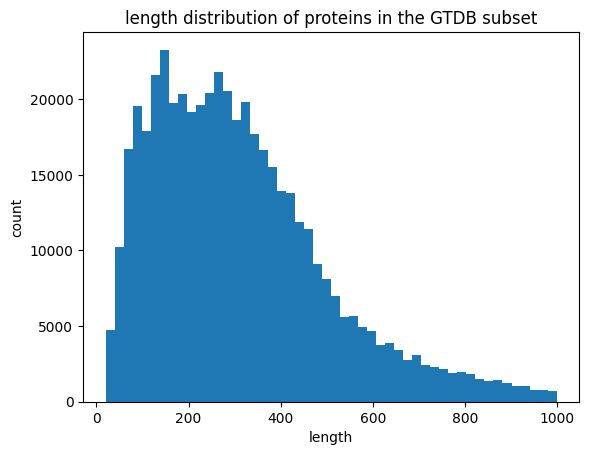

In [ ]:
print('Total number of proteins in the subset:', len(gtdb_df))

# Also want to look at the length distribution, and possibly get rid of any clear outliers. 
gtdb_df['length'] = gtdb_df.seq.apply(len)

# After looking at the initial length distribution, there are definitely some crazy outliers. 
# It seems like there *can* be bacterial sequences that long, but I don't want to deal with them. 
length_threshold = 1000
# print((gtdb_df.length >= length_cutoff).sum(), f'proteins exceed the length threshold of {length_threshold}.')

gtdb_df = gtdb_df[gtdb_df.length < length_threshold]
gtdb_df.to_csv(os.path.join(DATA_DIR, 'validation', f'bac120_proteins_r207_subset_max_length_{length_threshold}.csv'))
print(f'Average length of proteins with length < {length_threshold} aa:', gtdb_df.length.mean())

fig, ax = plt.subplots()
ax.hist(gtdb_df.length, bins=50)
ax.set_title('length distribution of proteins in the GTDB subset')
ax.set_xlabel('length')
ax.set_ylabel('count')
plt.show()

In [ ]:
train_dataset = Dataset.from_hdf(os.path.join(DATA_DIR, 'train.h5'))

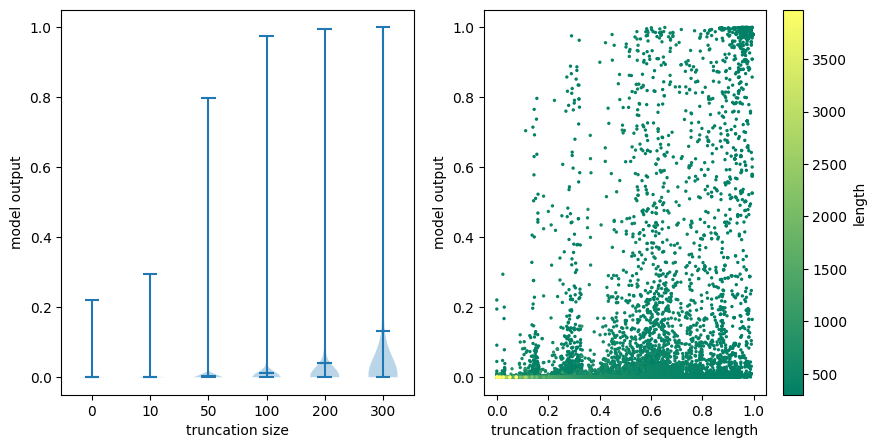

In [ ]:
# Seems like a good idea to express truncation as a proportion of the protein's length. 
model_balance_batches = Classifier.load(os.path.join(MODELS_DIR, 'model_balance_batches.pkl'))
dataset = Dataset.from_hdf(os.path.join(DATA_DIR, 'uniprot_truncated.h5'), feature_type='plm')

metadata = dataset.metadata.copy()
metadata['prediction'] = model_balance_batches.predict(dataset, threshold=None).ravel()
metadata = metadata.sort_values('length')
data, positions = [], []
for truncation, df in metadata.groupby('truncation'):
    # data.append(np.round(df.prediction.values, 1))
    data.append(df.prediction.values.ravel())
    positions.append(truncation)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].violinplot(np.array(data).T, showmeans=True)
axes[0].set_xticklabels([0] + positions)
axes[0].set_ylabel('model output')
axes[0].set_xlabel('truncation size')

# cmap = matplotlib.colors.Colormap('Blues', N=256)
# cmap = plt.get_cmap('Blues')
norm = matplotlib.colors.Normalize(vmin=min(metadata.length.values.ravel()), vmax=max(metadata.length.values.ravel()))
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap='summer')

colors = cmap.to_rgba(metadata.length.values.ravel())

axes[1].scatter(metadata.truncation / metadata.length, metadata.prediction, s=2, c=colors)
cbar = plt.colorbar(ax=axes[1], mappable=cmap)
cbar.set_label('length')
axes[1].set_xlabel('truncation fraction of sequence length')
axes[1].set_ylabel('model output')

plt.show()

In [ ]:
positions

[0, 10, 50, 100, 200, 300]

In [ ]:
sec_df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sec.csv'))

print('Fraction of bacteria:', sec_df.domain.str.match('Bacteria').mean())
print('Fraction of archaea:', sec_df.domain.str.match('Archaea').mean())
print('Fraction of eukaryotes:', sec_df.domain.str.match('Eukaryota').mean())
print('Fraction of viruses:', sec_df.domain.str.match('Viruses').mean())

# As far as selenoprotein machinery goes, I think it's more similar between archaea and eukaryotes than with bacteria. 
# (though I need to find a source for that). Perhaps it would be interesting to hold out non-bacteria, and see how it generalizes later on. 
 

Fraction of bacteria: 0.8265916285613788
Fraction of archaea: 0.01175820310537159
Fraction of eukaryotes: 0.15451484850007538
Fraction of viruses: 0.0002512436560976835


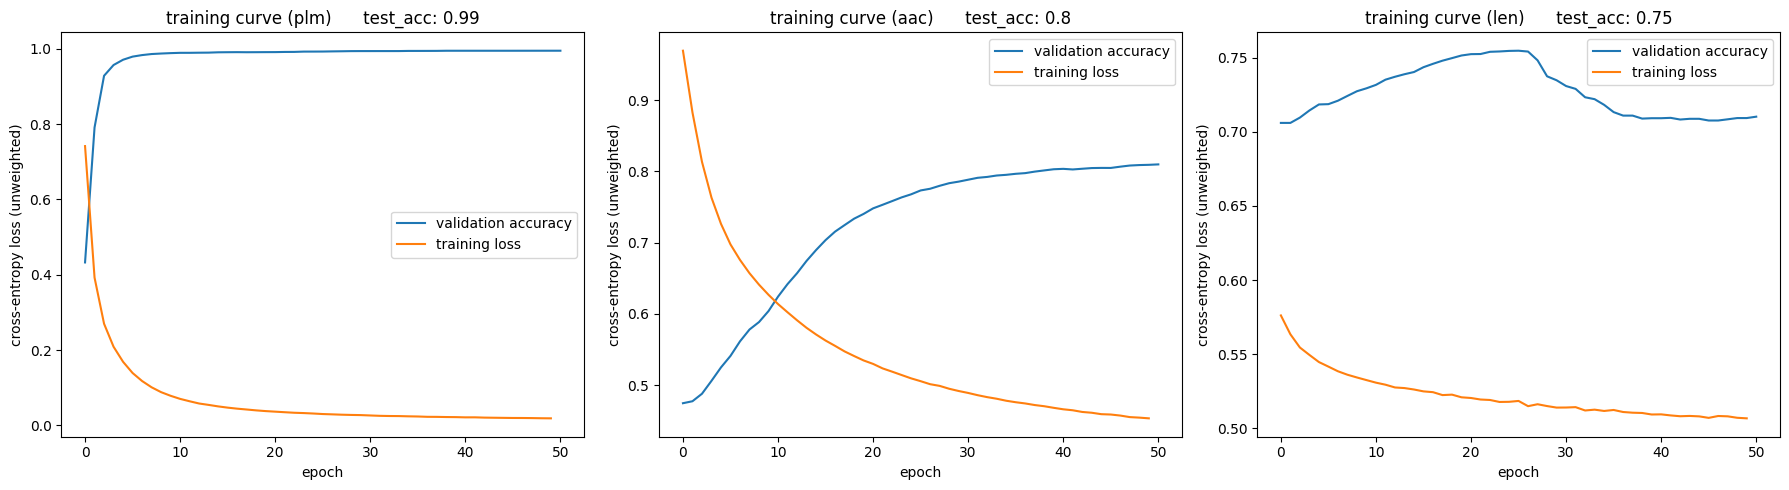

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

for feature_type, ax in zip(['plm', 'aac', 'len'], axes):

    model = Classifier.load(os.path.join(MODELS_DIR, f'binary_model_{feature_type}.pkl'))
    ax.plot(np.arange(len(model.val_accs)), model.val_accs)
    ax.plot(np.arange(len(model.train_losses)), model.train_losses) # , ls='--')

    test_dataset = BinaryDataset.from_hdf(os.path.join(DATA_DIR, 'test.h5'), feature_type=feature_type)
    predictions = model.predict(test_dataset).ravel()
    test_acc = balanced_accuracy_score(test_dataset.labels.numpy(), predictions)
    # ax.text(0.8, 0.8, f'test_acc: {np.round(test_acc, 2)}', transform=ax.transAxes)

    ax.set_title(f'training curve ({feature_type})      test_acc: {np.round(test_acc, 2)}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('cross-entropy loss (unweighted)')
    ax.legend(['validation accuracy', 'training loss',])

plt.tight_layout()
plt.show()

# Why is the validation accuracy so high? is it just converging really quickly?

In [ ]:
print(len(test_dataset.labels))
print(len(predictions.ravel()))

71744
71744


In [ ]:
test_dataset = Dataset.from_hdf(os.path.join(DATA_DIR, 'test.h5'))
test_predictions = model.predict(test_dataset)

print('Test accuracy:', balanced_accuracy_score(test_dataset.labels, test_predictions))
# print('Test accuracy (balance batches):', balanced_accuracy_score(test_dataset.labels, test_predictions_bb))

# For 2000 epochs, learning rate e-8: 0.9943182517917055
# For 1000 epochs, learning rate e-6: 0.9891197858353995
# For 1000 epochs, learning rate e-7: 0.9915394770126511
# For 1000 epochs, learning rate e-8: 0.9939928067866008


Test accuracy: 0.9939179416532318


In [ ]:
# Want to make sure the balanced batch sampler is working correctly. 
# train_dataset = Dataset(pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('gene_id'))
dataloader = get_dataloader(train_dataset, batch_size=16, balance_batches=True)

get_dataloader: 3359210 samples required for dataset coverage.


In [ ]:
r0, r1 = [], []
n_batches = len(dataloader)
print(n_batches, 'batches in the DataLoader.')
gene_ids = []

for batch in dataloader:
    batch_labels = batch['label']
    batch_size = len(batch_labels)
    r0.append((batch_size - batch_labels.sum().item()) / batch_size)
    r1.append(batch_labels.sum().item() / batch_size)
    gene_ids.append(batch['gene_id'])

gene_ids = np.unique(np.concatenate(gene_ids).ravel())
print(f'Saw {len(gene_ids)} unique gene IDs.')
print('Average proportion of selenoproteins per batch:', np.mean(r1))
print('Average proportion of non-selenoproteins per batch:', np.mean(r0))


209951 batches in the DataLoader.
Saw 371236 unique gene IDs.
Average proportion of selenoproteins per batch: 0.4996790917880839
Average proportion of non-selenoproteins per batch: 0.5003209082119161
